E:\ANACONDA\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Number of data point for race dataframe: 25840
Number of data point for driver dataframe: 857
Data frame race information
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25840 entries, 0 to 25839
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   resultId       25840 non-null  int64         
 1   raceId         25840 non-null  int64         
 2   driverId       25840 non-null  int64         
 3   constructorId  25840 non-null  int64         
 4   grid           25840 non-null  int64         
 5   points         25840 non-null  float64       
 6   rank           25840 non-null  object        
 7   year           25840 non-null  int64         
 8   round          25840 non-null  int64         
 9   circuitId      25840 non-null  int64         
 10  date           25840 non-null  datetime64[ns]
 11  code           25840 non-null  object        
 12  forename       25840 non-null  object        
 13 

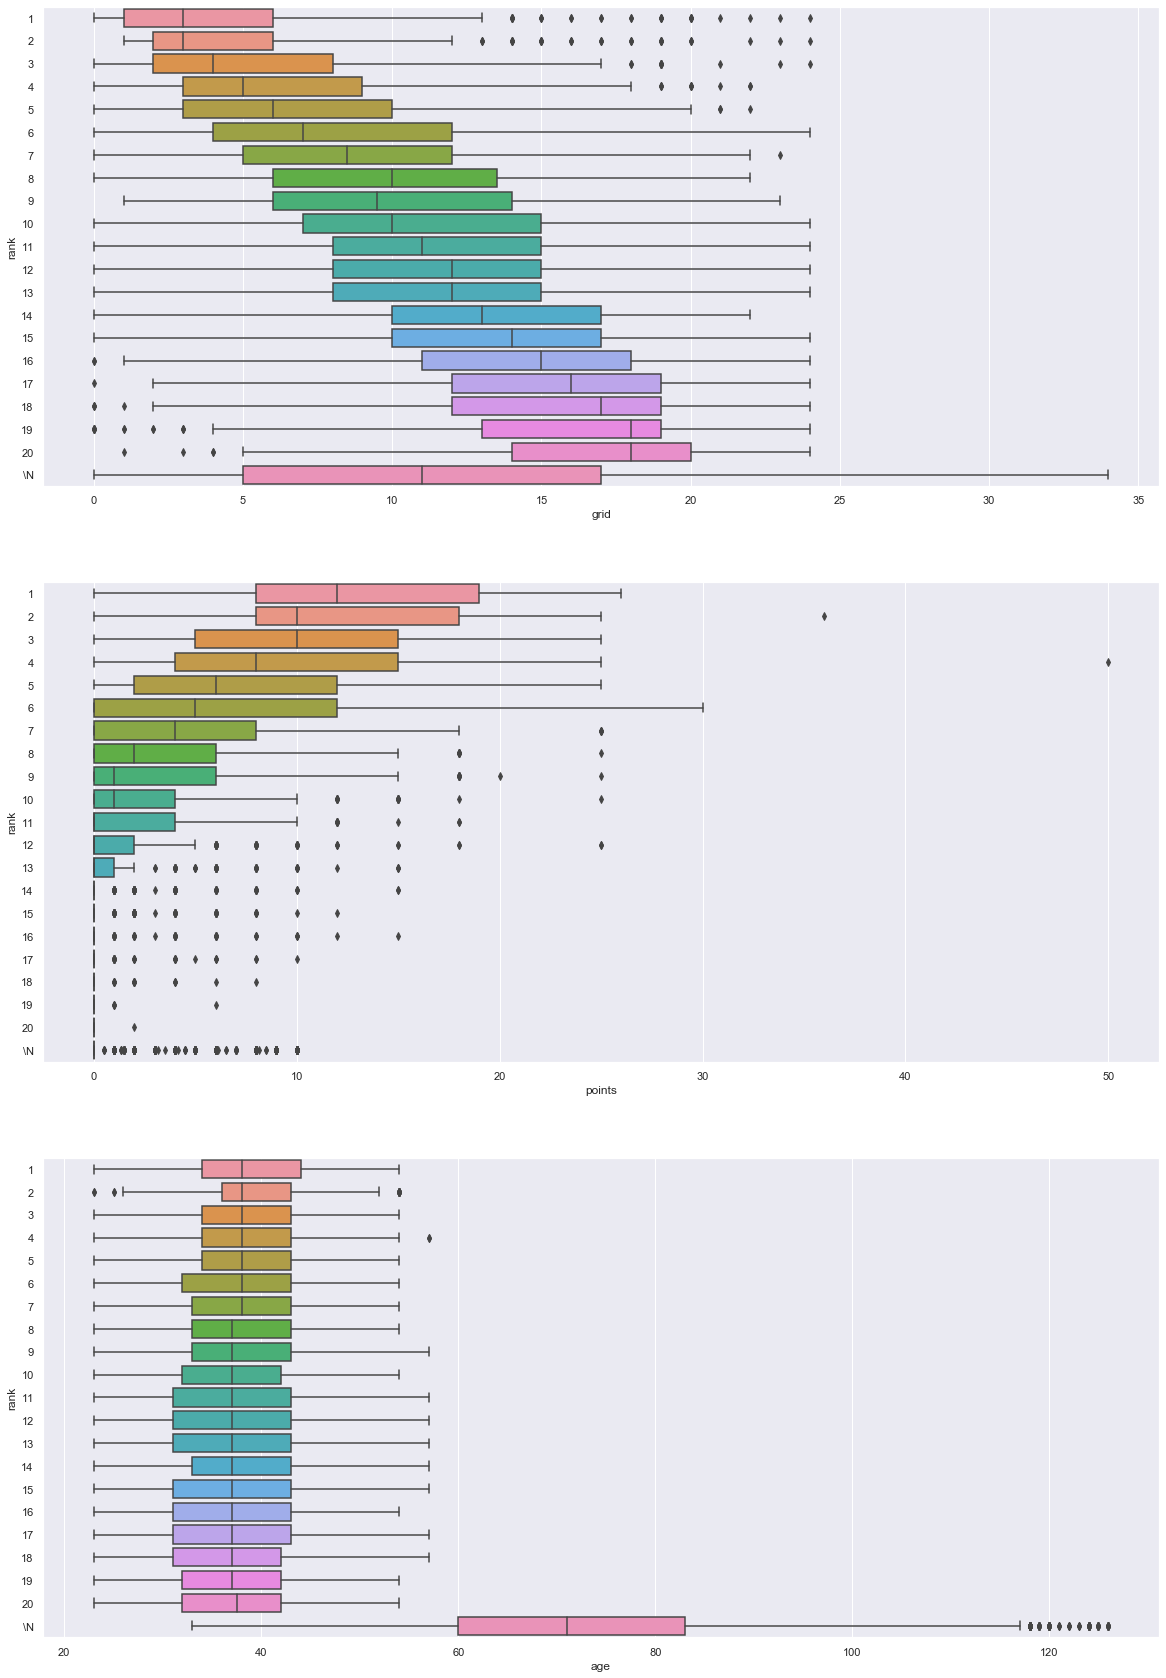

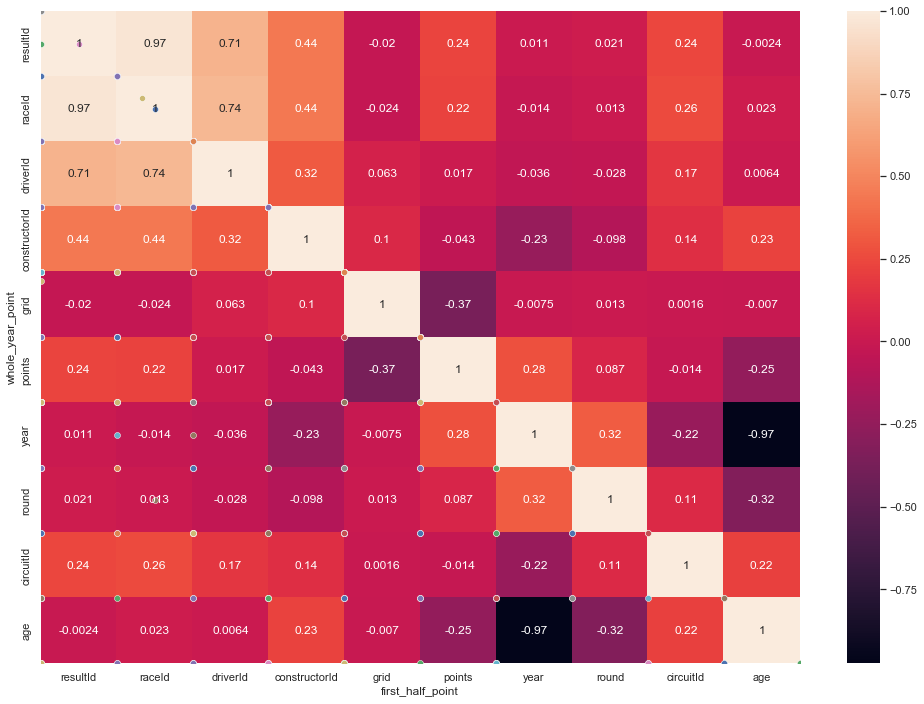

In [1]:
import pandas as pd
import numpy as np

#visualization tools
import matplotlib.pyplot as plt

import seaborn as sns
from datetime import datetime
sns.set()
from os import listdir
from os.path import isfile, join




circuits = pd.read_csv("mydata/circuits.csv")
constructor_results = pd.read_csv('mydata/constructor_results.csv', delimiter=',')

qualifying = pd.read_csv('mydata/qualifying.csv', delimiter=',')
qualifying = qualifying[['driverId', 'position']]

laptimes = pd.read_csv('mydata/lap_times.csv', delimiter=',')
laptimes = laptimes[['raceId', 'driverId', 'lap', 'milliseconds']]

drivers = pd.read_csv('mydata/drivers.csv', delimiter=',')
driver_standings = pd.read_csv('mydata/driver_standings.csv', delimiter=',')
driver_result = pd.read_csv('mydata/results.csv', delimiter=',')

races = pd.read_csv('mydata/races.csv', delimiter=',')
races_date = races[['date', 'circuitId', 'raceId']]
races_date['date'] = pd.to_datetime(races_date['date'])

# merge
df1 = pd.merge(driver_result, races, on='raceId')
df_race = pd.merge(df1, drivers, on='driverId')

posterior_data = ['laps', 'milliseconds', 'fastestLap', 'fastestLapTime', 'fastestLapSpeed', 'statusId', 'time_x',
                  'time_y', 'positionOrder']
df_race = df_race.drop(columns=posterior_data)

# Drop redundant positon and positionText column
df_race = df_race.drop(
    columns=['position', 'positionText', 'number_x', 'sprint_date', 'sprint_time', 'driverRef', 'number_y',
             'nationality', 'url_x', 'url_y', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'quali_date',
             'quali_time', 'fp3_date', 'fp3_time', 'name'])
df1 = pd.merge(driver_result, races, on ='raceId')
df_race

df_race = pd.merge(df1, drivers, on = 'driverId')

posterior_data = ['laps', 'milliseconds', 'fastestLap', 'fastestLapTime', 'fastestLapSpeed', 'statusId', 'time_x', 'time_y', 'positionOrder']
df_race = df_race.drop(columns=posterior_data)

df_race = df_race.drop(columns=['position',  'positionText', 'number_x', 'sprint_date', 'sprint_time', 'driverRef', 'number_y', 'nationality', 'url_x', 'url_y', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'quali_date', 'quali_time', 'fp3_date', 'fp3_time', 'name'])

df_race['dob'] = pd.to_datetime(df_race['dob'])
df_race['date'] = pd.to_datetime(df_race['date'])
#Add age column to dataframe
dates = datetime.today()-df_race['dob']
age = dates.dt.days/365
df_race['age'] = round(age)
df_race.head()

df_driver = drivers.copy()
df_driver['totalWins'] = 0

race_dates = races[['raceId', 'date']]
# CLEANING AND ADDING

# adding dates to each race
driver_standings = driver_standings.merge(race_dates[['raceId', 'date']], how='left', on='raceId')

# Convert the "date" column to a datetime object
driver_standings['date'] = pd.to_datetime(driver_standings['date'])

# Create a new column 'year' to extract the year from the 'date' column
driver_standings['year'] = driver_standings['date'].dt.year
# driver_standings_csv.head()

# count the number of races each driver has driven in
num_races_per_driver = driver_standings.groupby('driverId')['raceId'].nunique()
num_races_per_driver_df = num_races_per_driver.reset_index()
num_races_per_driver_df = num_races_per_driver_df.rename(columns={'raceId': 'totalRaces'})
# num_races_per_driver_df.head()

# FINDING TOTAL WINS FOR EACH DRIVER
for index, row in df_driver.iterrows():
    driverId = row['driverId']

    # filtering out rows with ['driverId'] == driverId
    driver_standings_csv_driverId = driver_standings[driver_standings['driverId'] == driverId]

    # Group the dataframe by year and find the maximum date for each year
    latest_day_in_year = driver_standings_csv_driverId.groupby(driver_standings_csv_driverId['date'].dt.year)[
        'date'].max()

    # Use the latest day in each year to filter the original dataframe
    filtered_dataframe = driver_standings_csv_driverId.loc[
        driver_standings_csv_driverId['date'].isin(latest_day_in_year)]

    total_wins = filtered_dataframe['wins'].sum()

    index = df_driver.index[df_driver['driverId'] == driverId].tolist()[0]
    df_driver.at[index, 'totalWins'] = total_wins

# adding dates to each race
df_driver = df_driver.merge(num_races_per_driver_df, how='left', on='driverId')

# calculate win rate and drop totalWins columns
df_driver['winRate'] = df_driver['totalWins'] / df_driver['totalRaces']
df_driver = df_driver.drop(['totalWins'], axis=1)
df_driver['dob'] = pd.to_datetime(df_driver['dob'])
df_driver['age'] = 2023 - df_driver['dob'].dt.year

# PRINT CURRENT DATASET
df_driver.head()

idx = laptimes.groupby('raceId')['milliseconds'].idxmin()

# Use the index to select the rows with the minimum milliseconds for each raceId
df_min_milliseconds = laptimes.loc[idx]

# Sort the result by raceId
df_min_milliseconds.sort_values('raceId', inplace=True)

counts = pd.DataFrame(df_min_milliseconds['driverId'].value_counts())
counts.columns = ['totalFastestLaps']
counts['driverId'] = counts.index
counts.reset_index(drop=True, inplace=True)

# adding totalFastestLaps to df maindata_wnames
df_driver = df_driver.merge(counts, how='left', on='driverId')
df_driver = df_driver.fillna(0)

# calculate fastest lap rate and drop totalFastestLaps
df_driver['fastestLapRate'] = df_driver['totalFastestLaps'] / df_driver['totalRaces']
df_driver = df_driver.drop(['totalFastestLaps'], axis=1)

# PRINT CURRENT DATASET
df_driver.head()

# COUNTING THE NUMBER OF QUALIFYING WINS
# Group by driverId and position, then count the number of occurrences
position_1_counts = qualifying[qualifying['position'] == 1].groupby('driverId')['position'].count().reset_index()

# Rename the 'position' column to 'position_1_count'
position_1_counts = position_1_counts.rename(columns={'position': 'position_1_count'})

# # Print the resulting DataFrame
# position_1_counts.head()

# merge
df_driver = df_driver.merge(position_1_counts, how='left', on='driverId')
df_driver = df_driver.fillna(0)

# calculate fastest lap rate and drop totalFastestLaps
df_driver['qualifyingWinRate'] = df_driver['position_1_count'] / df_driver['totalRaces']
df_driver = df_driver.drop(['position_1_count'], axis=1)

# filling in NaN values for qualifyingWinRate
df_driver.fillna(0, inplace=True)

df_driver.head()

print("Number of data point for race dataframe: " + str(df_race.shape[0]))
print("Number of data point for driver dataframe: " + str(df_driver.shape[0]))

print("Data frame race information")
df_race.info()

print('\n\n')
print("Data frame driver information")
df_driver.info()


#Categorical Value
f, axes = plt.subplots(3, 1, figsize=(20, 30))
df_cat = pd.DataFrame(df_race[['grid', 'points', 'age', 'rank']])
count = 0
for col in df_cat:
    if col!='rank':
        sns.boxplot(data=df_race, x=col, y='rank', order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17','18', '19', '20', '\\N'], ax=axes[count])
        count = count + 1

df_race.describe()

plt.figure(figsize=(17,12))
sns.heatmap(df_race.corr(),annot=True)


driver_result_withdate_divided = df_race.copy()
driver_result_withdate_divided['firstHalf'] = (driver_result_withdate_divided['date'].dt.month <= 6).astype(int)

driver_result_withdate_groupby_year_divided = driver_result_withdate_divided.groupby([driver_result_withdate_divided['date'].dt.year, driver_result_withdate_divided['firstHalf'], driver_result_withdate_divided['driverId']])
point_year_divided = driver_result_withdate_groupby_year_divided["points"].sum().unstack()

age_year = driver_result_withdate_groupby_year_divided["age"].mean().unstack()
age_year

#Loop through each team
#Column name is ID of each team
point_first_half_all = []
whole_year_point_all = []
for column in point_year_divided:
    point_year_driver_divided = point_year_divided[column].unstack()
    point_first_half = []
    whole_year_point = []
    ages = []
    age_one_year = age_year[column].unstack()
    point_year_driver_divided = pd.merge(point_year_driver_divided, age_one_year, on='date')
    #Loop through each year
    for row in point_year_driver_divided.iterrows():
        if not np.isnan(row[1][0]) and not np.isnan(row[1][1]) and (not np.isnan(row[1][2]) or not np.isnan(row[1][3])):
            if not np.isnan(row[1][2]):
                age = row[1][2]
            else:
                age = row[1][3]
            ages.append(age)
            point_first_half.append(row[1][1])
            point_first_half_all.append((row[1][1], age))
            whole_year_point.append(row[1][0]+row[1][1])
            whole_year_point_all.append(row[1][0])
    new_df = pd.DataFrame({'first_half_point':point_first_half, 'ages': ages, 'whole_year_point':whole_year_point})
    sns.scatterplot(x='first_half_point', y='whole_year_point', data=new_df)


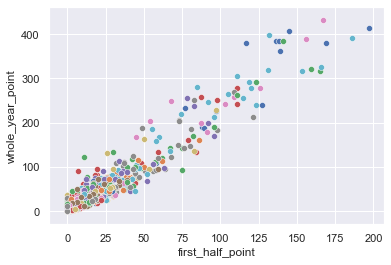

In [2]:
#Loop through each team
#Column name is ID of each team
point_first_half_all = []
whole_year_point_all = []
for column in point_year_divided:
    point_year_driver_divided = point_year_divided[column].unstack()
    point_first_half = []
    whole_year_point = []
    ages = []
    age_one_year = age_year[column].unstack()
    point_year_driver_divided = pd.merge(point_year_driver_divided, age_one_year, on='date')
    #Loop through each year
    for row in point_year_driver_divided.iterrows():
        if not np.isnan(row[1][0]) and not np.isnan(row[1][1]) and (not np.isnan(row[1][2]) or not np.isnan(row[1][3])):
            if not np.isnan(row[1][2]):
                age = row[1][2]
            else:
                age = row[1][3]
            ages.append(age)
            point_first_half.append(row[1][1])
            point_first_half_all.append((row[1][1], age))
            whole_year_point.append(row[1][0]+row[1][1])
            whole_year_point_all.append(row[1][0])
    new_df = pd.DataFrame({'first_half_point':point_first_half, 'ages': ages, 'whole_year_point':whole_year_point})
    sns.scatterplot(x='first_half_point', y='whole_year_point', data=new_df)